# Conceptual Model RELAMPAGO Jan. 25th Case

Ivan Arias

2019/10/21

In [1]:
import pyart
import chivo_plot as plot
import importlib
import numpy as np
import scipy.ndimage as spyi
import matplotlib.pyplot as plt


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



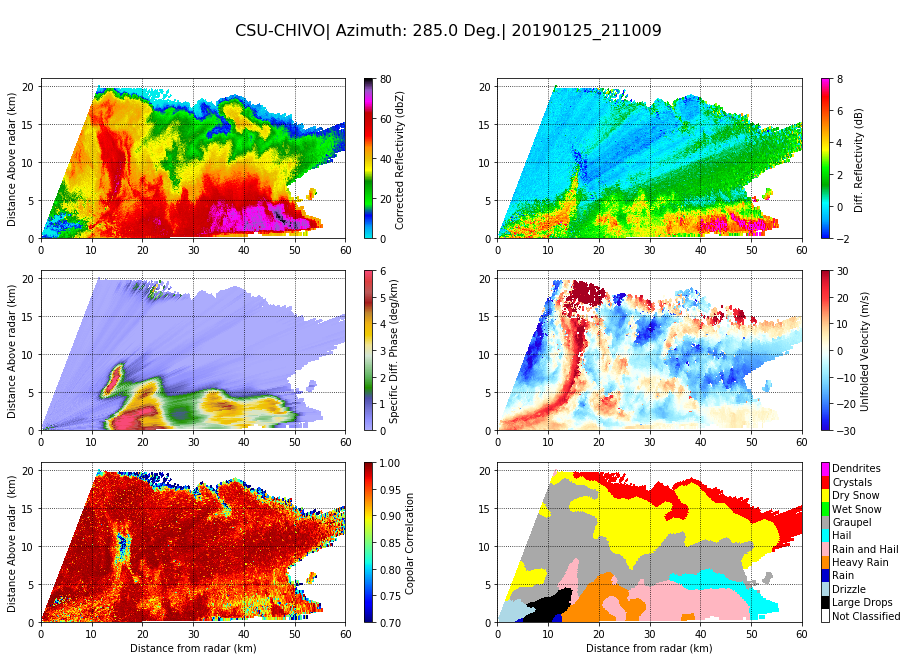

In [192]:
importlib.reload(plot)

filename_drops = '/net/denali/storage2/radar2/tmp/Ivan/Field_Campaigns/Relampago/Analisis/Attenuation/NetCDF/20190125_2100/DROPS/cfrad.20190125_210858.592_to_20190125_211009.717_col-radar_REL_RHI30_RHI.nc'
filename_sigmet = '/net/denali/storage/radar/RELAMPAGO/RAW/2019/01/25/COL20190125_210858'
#'/net/denali/storage/radar/RELAMPAGO/RAW/2019/01/25/COL20190125_211011'
sweep = 0
fig = plot.rhi_drops_4dd(filename_drops, filename_sigmet, sweep)

<center> RHI made using DROPS for attenuation correction and 4dd to unfold velocity </center>

**Make Zdr plot with reflectivity contour lines**

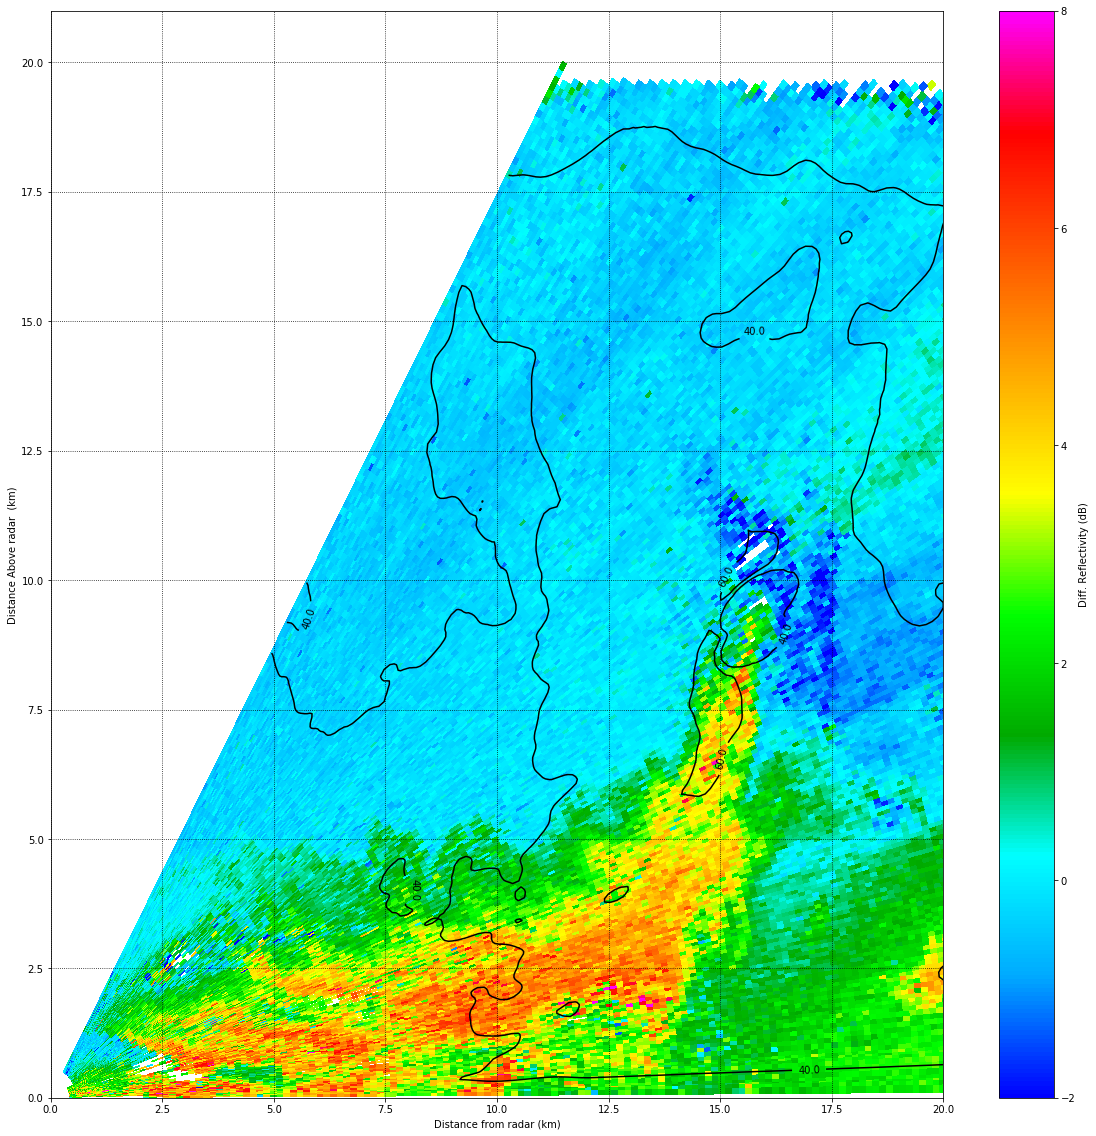

In [104]:
radar = pyart.io.read(filename_drops)
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_transition()
gatefilter.exclude_invalid('corrected_reflectivity')
gatefilter.exclude_invalid('corrected_differential_phase')
gatefilter.exclude_outside('corrected_reflectivity', -20, 100)
gatefilter.exclude_outside('corrected_cross_correlation_ratio', 0.6, 1)

display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=[20, 20])
ax = fig.add_subplot(111)

# plot velocity
# cmap is the color ramp being used in this case blue to red no 18
# https://github.com/ARM-DOE/pyart/blob/master/pyart/graph/cm.py
# for more information

display.plot('corrected_differential_reflectivity', sweep = sweep, vmin = -2, vmax = 8, fig = fig, gatefilter = gatefilter,
             ax = ax, cmap= pyart.graph.cm.RefDiff, colorbar_label = 'Diff. Reflectivity (dB)', title = '')
display.set_limits(ylim=[0, 21])
display.set_limits(xlim=[0, 20])
display.plot_grid_lines(ax=None, col='k', ls=':')

# line commented out to show reflectivity
# display.plot('reflectivity', sweep=sweep, vmin=-0, vmax=45.0, fig=fig,ax=ax)

# get data

start = radar.get_start(sweep)
end = radar.get_end(sweep) + 1
data = radar.get_field(sweep, 'corrected_reflectivity')
x, y, z = radar.get_gate_x_y_z(sweep, edges=False)

x /= 1000.0
y /= 1000.0
z /= 1000.0

# smooth out the lines
data = spyi.gaussian_filter(data, sigma = 1.5)

# calculate (R)ange
R = np.sqrt(x ** 2 + y ** 2) * np.sign(y)

# add contours
# creates steps 35 to 100 by 5
levels = np.arange(40, 100, 20)
# adds coutours to plot
contours = ax.contour(R, z, data, levels, linewidths=1.5, colors='k',
                      linestyles='solid', antialiased=True)

# adds contour labels (fmt= '%r' displays 10.0 vs 10.0000)
plt.clabel(contours, levels, fmt='%r', inline=True, fontsize = 10)

plt.show()

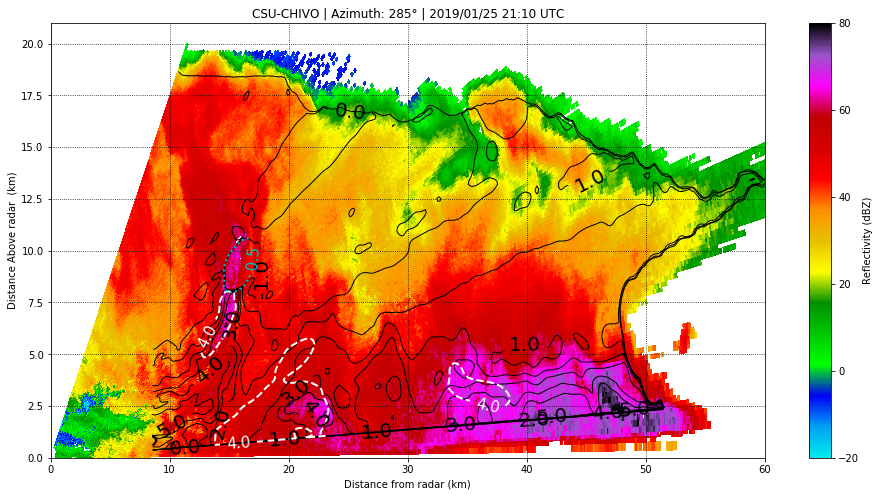

In [313]:
radar = pyart.io.read(filename_drops)
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_transition()
gatefilter.exclude_invalid('corrected_reflectivity')
gatefilter.exclude_invalid('corrected_differential_phase')
gatefilter.exclude_outside('corrected_reflectivity', -20, 100)
gatefilter.exclude_outside('corrected_cross_correlation_ratio', 0.6, 1)

display = pyart.graph.RadarDisplay(radar)

fig = plt.figure(figsize=[16, 8])
ax = fig.add_subplot(111)

display.plot('corrected_reflectivity', sweep = sweep, vmin = -20, vmax = 80, fig = fig, gatefilter = gatefilter,
             ax = ax, cmap = pyart.graph.cm.NWSRef, colorbar_label = 'Reflectivity (dBZ)', 
             title = 'CSU-CHIVO | Azimuth: 285° | 2019/01/25 21:10 UTC')
display.set_limits(ylim=[0, 21])
display.set_limits(xlim=[0, 60])
display.plot_grid_lines(ax=None, col='k', ls=':')

# get data

Zdr = radar.get_field(sweep, 'corrected_differential_reflectivity')
Z = radar.get_field(sweep, 'corrected_reflectivity')
Kdp = radar.get_field(sweep, 'corrected_specific_differential_phase')
rhohv = radar.get_field(sweep, 'corrected_cross_correlation_ratio')
x, y, z = radar.get_gate_x_y_z(sweep, edges=False)

x /= 1000.0
y /= 1000.0
z /= 1000.0

# calculate (R)ange
R = np.sqrt(x ** 2 + y ** 2)

# smooth out the lines and mask
#Zdr = np.ma.masked_where( Z < 10, Zdr)
#Zdr = np.ma.masked_where( R < 8, Zdr)
Zdr = spyi.gaussian_filter(Zdr, sigma = 2)
Kdp = spyi.gaussian_filter(Kdp, sigma = 2)
rhohv = spyi.gaussian_filter(rhohv, sigma = 2)

Zdr = np.ma.masked_where( R < 8.5, Zdr)
rhohv = np.ma.masked_where( Z < 20, rhohv)
rhohv = np.ma.masked_where( z < 5, rhohv)
rhohv = np.ma.masked_where( R > 30, rhohv)
rhohv = np.ma.masked_where( z > 15, rhohv)

# add contours
# creates steps 35 to 100 by 5
levels_Zdr = np.arange(-1, 6, 1)
levels_Kdp = np.arange(4, 6, 2)
levels_rhohv = np.arange(0.5, 0.54, 0.05)
# adds coutours to plot
contours_Zdr = ax.contour(R, z, Zdr, levels_Zdr, linewidths = 1, colors = 'k',
                      linestyles='solid', antialiased=True)
contours_Kdp = ax.contour(R, z, Kdp, levels_Kdp, linewidths= 2, colors = 'w',
                      linestyles='dashed', antialiased=True)
contours_rhohv = ax.contour(R, z, rhohv, levels_rhohv, linewidths= 2, colors = 'c',
                      linestyles = 'dotted', antialiased=True)

# adds contour labels (fmt= '%r' displays 10.0 vs 10.0000)
plt.clabel(contours_Zdr, levels_Zdr, fmt='%r', inline=True, fontsize = 20)
plt.clabel(contours_Kdp, levels_Kdp, fmt='%r', inline=True, fontsize = 15)
plt.clabel(contours_rhohv, levels_rhohv, fmt='%r', inline=True, fontsize = 15)

plt.show()

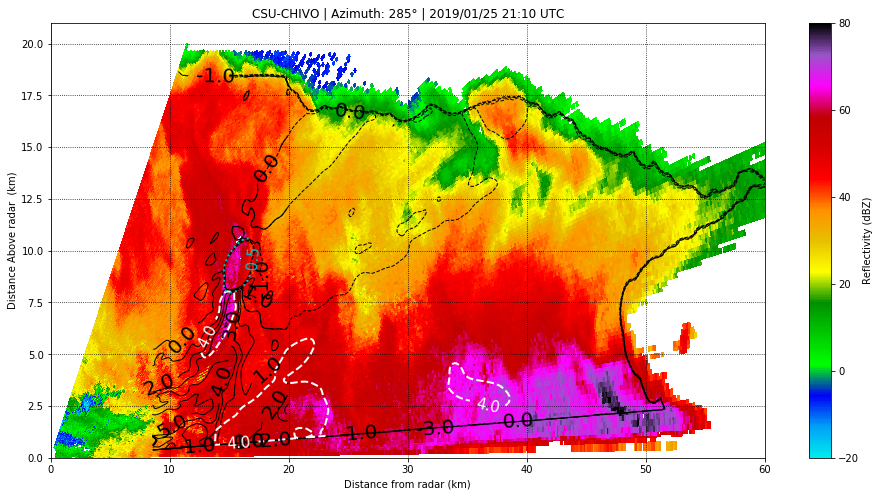

In [321]:
radar = pyart.io.read(filename_drops)
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_transition()
gatefilter.exclude_invalid('corrected_reflectivity')
gatefilter.exclude_invalid('corrected_differential_phase')
gatefilter.exclude_outside('corrected_reflectivity', -20, 100)
gatefilter.exclude_outside('corrected_cross_correlation_ratio', 0.6, 1)

display = pyart.graph.RadarDisplay(radar)

fig = plt.figure(figsize=[16, 8])
ax = fig.add_subplot(111)

display.plot('corrected_reflectivity', sweep = sweep, vmin = -20, vmax = 80, fig = fig, gatefilter = gatefilter,
             ax = ax, cmap = pyart.graph.cm.NWSRef, colorbar_label = 'Reflectivity (dBZ)', 
             title = 'CSU-CHIVO | Azimuth: 285° | 2019/01/25 21:10 UTC')
display.set_limits(ylim=[0, 21])
display.set_limits(xlim=[0, 60])
display.plot_grid_lines(ax=None, col='k', ls=':')

# get data

Zdr = radar.get_field(sweep, 'corrected_differential_reflectivity')
Zdr_shadow = radar.get_field(sweep, 'corrected_differential_reflectivity')
Z = radar.get_field(sweep, 'corrected_reflectivity')
Kdp = radar.get_field(sweep, 'corrected_specific_differential_phase')
rhohv = radar.get_field(sweep, 'corrected_cross_correlation_ratio')
x, y, z = radar.get_gate_x_y_z(sweep, edges=False)

x /= 1000.0
y /= 1000.0
z /= 1000.0

# calculate (R)ange
R = np.sqrt(x ** 2 + y ** 2)

# smooth out the lines and mask
#Zdr = np.ma.masked_where( Z < 10, Zdr)
#Zdr = np.ma.masked_where( R < 8, Zdr)
Zdr = spyi.gaussian_filter(Zdr, sigma = 2)
Zdr_shadow = spyi.gaussian_filter(Zdr_shadow, sigma = 2)
Kdp = spyi.gaussian_filter(Kdp, sigma = 2)
rhohv = spyi.gaussian_filter(rhohv, sigma = 2)

Zdr = np.ma.masked_where( R < 8.5, Zdr)
Zdr = np.ma.masked_where( R > 20, Zdr)
Zdr_shadow = np.ma.masked_where( R < 15, Zdr_shadow)
#Zdr_shadow = np.ma.masked_where( R > 20, Zdr_shadow)
rhohv = np.ma.masked_where( Z < 20, rhohv)
rhohv = np.ma.masked_where( z < 5, rhohv)
rhohv = np.ma.masked_where( R > 30, rhohv)
rhohv = np.ma.masked_where( z > 15, rhohv)

# add contours
# creates steps 35 to 100 by 5
levels_Zdr = np.arange(-1, 6, 1)
levels_Zdr_shadow = np.arange(-3, 1, 1)
levels_Kdp = np.arange(4, 6, 2)
levels_rhohv = np.arange(0.5, 0.54, 0.05)
# adds coutours to plot
contours_Zdr = ax.contour(R, z, Zdr, levels_Zdr, linewidths = 1, colors = 'k',
                      linestyles='solid', antialiased=True)
contours_Zdr_shadow = ax.contour(R, z, Zdr_shadow, levels_Zdr_shadow, linewidths = 1, colors = 'k',
                      linestyles='dashed', antialiased=True)
contours_Kdp = ax.contour(R, z, Kdp, levels_Kdp, linewidths= 2, colors = 'w',
                      linestyles='dashed', antialiased=True)
contours_rhohv = ax.contour(R, z, rhohv, levels_rhohv, linewidths= 2, colors = 'c',
                      linestyles = 'dotted', antialiased=True)

# adds contour labels (fmt= '%r' displays 10.0 vs 10.0000)
plt.clabel(contours_Zdr, levels_Zdr, fmt='%r', inline=True, fontsize = 20)
plt.clabel(contours_Zdr_shadow, levels_Zdr_shadow, fmt='%r', inline=True, fontsize = 20)
plt.clabel(contours_Kdp, levels_Kdp, fmt='%r', inline=True, fontsize = 15)
plt.clabel(contours_rhohv, levels_rhohv, fmt='%r', inline=True, fontsize = 15)

plt.show()